# Imoports

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, BatchNormalization, Dropout
# Set maximum VRAM usage
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7400)])

import cv2
import numpy as np 
import random
import pandas as pd
import matplotlib.pyplot as plt

import time
import datetime
import os
import sys
import multiprocessing
from tqdm import tqdm
from typing import List, Tuple, Union

In [3]:
# Dataset folder
dataPath = r"C:\Users\Miaad\Downloads\Compressed\archive_5\Extracted Faces\Extracted Faces"

# Helper Class
This class provides multiple methods to load images, manage files, and generate plots. Refer to the documentation for more information.

In [4]:
class Helper:
    @staticmethod
    def getSubDirs(directory: str, returnAbsPath: bool = True) -> list:
        """
        This method returns the list of subdirectories within the given directory.

        Parameters:
            directory (str): The path to the directory to scan.
            returnAbsPath (bool, optional): If True, returns a list of absolute paths. Defaults to True.

        Returns:
            list: A list of subdirectories.
        
        Raises:
            ValueError: If no subdirectories are found in the given directory.
        """
        
        subDirs = []
        for entry in os.scandir(directory):
            if not entry.is_dir():
                continue

            folderName = entry.name
            if returnAbsPath:
                subDirs.append(os.path.join(directory, folderName))

            else:
                subDirs.append(folderName)
        
        if len(subDirs) == 0:
            raise ValueError(f"No subdirectory found in directory {directory}")
            
        return subDirs
    
    
    @staticmethod
    def getFiles(directory: str, extension: str = 'jpg', returnAbsPath: bool = True) -> list:
        """
        This method returns the list of files with the given extension within the given directory.

        Parameters:
            directory (str): The path to the directory to scan.
            extension (str, optional): The extension of the files to count. Default is 'jpg'.
            returnAbsPath (bool, optional): If True, returns a list of absolute paths. Default is True.

        Returns:
            list: A list of file directories.

        Raises:
            ValueError: If no files are found in the given directory.
        """
        
        fileDirs = []
        for entry in os.scandir(directory):
            if not entry.is_file() or not entry.name.endswith(f'.{extension}'):
                continue

            fileName = entry.name
            if returnAbsPath:
                fileDirs.append(os.path.join(directory, fileName))

            else:
                fileDirs.append(fileName)
        
        if len(fileDirs) == 0:
            raise ValueError(f"No files found in directory {directory}")
            
        return fileDirs
    
    
    @staticmethod
    def countFiles(directory: str, extension: str = 'jpg') -> int:
        """
        This method counts the number of files with the given extension within the given directory.

        Parameters:
            directory (str): The path to the directory to count files in.
            extension (str, optional): The extension of the files to count. Default is 'jpg'.

        Returns:
            int: The number of files with the given extension within the given directory.
        """
        counter = 0
        for entry in os.scandir(directory):
            if entry.is_file() and entry.name.endswith(f'.{extension}'):
                counter += 1

        return counter
    
    
    @staticmethod
    def loadImage(directory: str, toGrayscale: bool = False, newSize: tuple = None) -> Tuple[np.ndarray, tuple]:
        """
        This method loads an image from the given directory.

        Parameters:
            directory (str): The path to the image to load.
            toGrayscale (bool, optional): If True, converts the image to grayscale. Default is False.
            newSize (tuple, optional): If not None, the image will be resized to the given size.

        Returns:
            tuple: A tuple of the loaded image and image shape.

        Raises:
            FileNotFoundError: If the image is not found in the given directory.
        """
        
        img = cv2.imread(directory)
        if type(img) == type(None):
            raise FileNotFoundError(f"Image not found in {directory}.")

        imgShape = img.shape

        if toGrayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if newSize != None:
            img = cv2.resize(img, newSize, interpolation=cv2.INTER_AREA)

        return np.array(img), imgShape
        
        
    @staticmethod
    def plot(images, titles, figSize, isBGR=True, nCols=7):
        """
        This method allows you to display a collection of images in a grid, with titles for each image.

        Parameters:
        - `images` (list): A list of images.
        - `titles` (list): A list of strings, representing the title for each image. The length of `titles` should be equal to the length of `images`.
        - `figSize` (tuple): The size of the figure.
        - `isBGR` (bool, optional): Indicates whether the input images are in BGR format (default is True).
        - `nCols` (int, optional): The number of columns in the grid (default is 3).

        Returns:
        None
        """
        
        # Check if the images and the titles have the same length
        if len(images) != len(titles):
            raise ValueError("Images and titles must have the same length")
        
        # Calculate the number of rows required for the figure
        nRows = int(np.ceil(len(images) / nCols))
        
        # Create the fig
        fig, axes = plt.subplots(nrows=nRows, ncols=nCols, figsize=figSize)

        for ax, img, title in zip(axes.flat, images, titles):
            if isBGR:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ax.imshow(img)
            ax.set_title(title)
        
        fig.tight_layout()         # Adjusts the scaling to prevets overlap
        plt.show()

# Generating Metadata For The Images
This function loads all the images found in the dataset directory, and assigns a unique class and image ID to each image. The data is then split into training and testing sets based on the specified splitRatio parameter.

In [5]:
def genMetadata(dataDir: str, splitRatio: int = 0.01) -> pd.DataFrame:
    """
    Generates metadata for images in the given directory.

    Parameters:
        dataDir (str): The path to the directory containing the images.

    Returns:
        pandas.DataFrame: A dataframe containing the metadata of the images. The dataframe
        has four columns: "ImageID", "ClassID", "RelativePath", and "Shape". The "ImageID" column
        contains an ID for each image, the "ClassID" column contains an ID for each person
        in the image, the "RelativePath" column contains the relative paths of the images,
        and the "Shape" column contains the shape of the images in string format.

    Raises:
        OSError: If the specified directory does not exist or is not a directory.

    """
    
    # Check if the given directory exists
    if not os.path.isdir(dataDir):
        raise  OSError(f"{dataDir} is not a valid directory.")
    
    trainMetadata = {"ImageID": [], "ClassID": [], "RelativePath": [], "Shape": []}
    testMetadata = {"ImageID": [], "ClassID": [], "RelativePath": [], "Shape": []}
    
    # Load and shuffle the directories
    subDirs = Helper.getSubDirs(dataDir, returnAbsPath=True)
    random.shuffle(subDirs)
    
    nClasses = len(subDirs)
    splitIndex = int(nClasses * splitRatio)
    
    # Iterate over the data directory and generate metadata
    imageID = 0
    for classID, subDir in enumerate(subDirs):
        imgNames = Helper.getFiles(os.path.join(dataDir, subDir), extension='jpg', returnAbsPath=False)    

        # Iterating over the images in each subdirectory
        for imgName in imgNames: 
            imgPath = os.path.join(subDir, imgName)
            image, imageShape = Helper.loadImage(imgPath)
            
            relativePath = os.path.join(os.path.split(subDir)[-1], imgName)
            
            # Append the metadata to the lists based on the 'splitIndex'
            if classID < splitIndex:
                testMetadata["ImageID"].append(imageID)
                testMetadata["ClassID"].append(classID)
                testMetadata["RelativePath"].append(relativePath)
                testMetadata["Shape"].append(str(imageShape))
                
            else:
                trainMetadata["ImageID"].append(imageID)
                trainMetadata["ClassID"].append(classID)
                trainMetadata["RelativePath"].append(relativePath)
                trainMetadata["Shape"].append(str(imageShape))
            
            imageID += 1
    
    # Create the data frames
    testMetadata = pd.DataFrame(testMetadata) 
    trainMetadata = pd.DataFrame(trainMetadata)
    
    return trainMetadata, testMetadata


# ====================================================================================
trainMetadata, testMetadata = genMetadata(dataPath)

# Create Pairs

In [6]:
class PairBuilder:
    @staticmethod
    def createPairs(array: np.ndarray, IDs: np.ndarray, exculdeSameID: bool = False, verbose: bool = False) -> np.ndarray:
        """
        Creates pairs of images from an array and their respective IDs.

        Parameters:
        array (numpy array): An array of images.
        IDs (numpy array): An array of IDs for each image.
        exculdeSameID (bool): If True, pairs with the same ID are excluded. Default is False.
        verbose (bool): If True, shows a progress bar. Default is False.

        Returns:
        np.ndarray: A numpy array of pairs.
        """
        if len(array) != len(IDs):
            raise ValueError("array and IDs must have the same length.")

        array, IDs = np.array(array), np.array(IDs)

        # Calculate number of images
        n = len(array)

        # Create an empty array
        pairs = np.empty((n*(n-1)//2, 2), dtype=int)

        k = 0     # points to the current empty pos in the pairs array
        # Create pairs
        for i in (tqdm(np.arange(n)) if verbose else np.arange(n)):
            for j in np.arange(i + 1, n):
                if IDs[i] == IDs[j] and exculdeSameID == True:
                    continue

                # Add the pairs to the array
                pairs[k, 0] = array[i]
                pairs[k, 1] = array[j]
                k += 1
        
        # only Return the portion of the array that has been filled.
        return pairs[:k]   

    
    @staticmethod
    def buildPairsArray(DF: pd.DataFrame, negToPosRatio: int = 1) -> Tuple[np.ndarray, np.ndarray]:
        """
        Builds a numpy array of positive and negative pairs from a data frame.

        Parameters:
        DF (pd.DataFrame): The input data frame with columns "ImageID" and "ClassID".
        negToPosRatio (int): The ratio of negative to positive pairs to generate. Default is 1.

        Returns:
        A tuple of two numpy arrays: the first array contains the pairs, and the second array contains their corresponding labels.
        """

        # Shuffle the data frame
        DF = DF.sample(frac=1).reset_index(drop=True)

        # Number of unique class IDs in the data frame
        nClasses = len(DF["ClassID"].unique())

        # Create empty arrays
        positivePairs = np.empty((0, 2), dtype=int)
        negativePairs = np.empty((0, 2), dtype=int)

        # Generate all poosible positive pairs
        for i in tqdm(np.arange(nClasses)):
            positivePairs = np.concatenate((positivePairs, 
                                            PairBuilder.createPairs(DF.ImageID[DF["ClassID"] == i],
                                                                    DF.ClassID[DF["ClassID"] == i],
                                                                    exculdeSameID=False
                                                                    )))

        # Generate all poosible negative pairs
        negativePairs = PairBuilder.createPairs(DF.ImageID, DF.ClassID, exculdeSameID=True, verbose=True)

        # Randomly sample negative pairs to match the ratio of negative to positive pairs
        negativePairs = negativePairs[np.random.randint(0, len(negativePairs), size=int(len(positivePairs) * negToPosRatio))]

        positivePairs = np.array(positivePairs, dtype=int)
        negativePairs = np.array(negativePairs, dtype=int)

        # Create label for the pairs
        labels = np.concatenate((np.ones(len(positivePairs)), np.zeros(len(negativePairs))))

        return np.concatenate((positivePairs, negativePairs)), labels


# ====================================================================================================================================
print("Building train pairs:")
trainPairs, trainLabels = PairBuilder.buildPairsArray(trainMetadata, negToPosRatio=1)
print("Building test pairs:")
testPairs, testLabels = PairBuilder.buildPairsArray(testMetadata, negToPosRatio=1)

Building train pairs:


100%|█████████████████████████████████████████████████████████████████████████████████████| 6054/6054 [00:10<00:00, 574.97it/s]


Building test pairs:


100%|███████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53016.48it/s]


# Data Analysis

In [15]:
class Plotter():
    def __init__(self, dataPath):
        self.dataPath = dataPath
        self.subDirs = Helper.getSubDirs(self.dataPath, returnAbsPath=True)          # Each subdirectory contains images of a individual person
    
    
    def visualizeImages(self, nPersons=25, nImagesPerPerson=2, figSize=(15, 15)):
        """
        Visualizes a random selection of images from a directory containing subdirectories of images of individual persons.

        Parameters:
        - nPersons (int, optional): The number of persons to display images of. Default is 25.
        - nImagesPerPerson (int, optional): The number of images to display for each person. Default is 2.
        - figsize (tuple, optional): Figure size. Default is (15, 15)

        Returns:
        None

        Raises:
        None
        """
        images = []
        labels = []

        subDirs = self.subDirs              # Copy the list of subdirectories (Each subdirectory contains images of a individual person)
        random.shuffle(subDirs)             # Shuffle the list to select random persons

        for i in tqdm(range(nPersons)):
            randomDir = subDirs[i]                                        # Get a random subdirectory
            nImages = Helper.countFiles(randomDir, extension='jpg')       # Get the number of images in the subdirectory
            imgPaths = Helper.getFiles(randomDir, extension='jpg', returnAbsPath=True)    

            for j, imgPath in enumerate(imgPaths):
                if j == nImagesPerPerson or j == nImages:                  # Break if the deired number of images have been displayed
                    break

                img, imgShape = Helper.loadImage(imgPath)  
                images.append(img)
                labels.append(f"Person {i + 1}")

        Helper.plot(images, labels, isBGR=True, figSize=figSize)         


    def plotImgCountHist(self):
        """
        Plots a histogram showing the distribution of the number of images per person in the data directory.

        Returns:
            None
        """
        counts = {}

        # Count the number of images for each person
        for personID, subDir in enumerate(self.subDirs):
            counts[personID] = Helper.countFiles(subDir)

        # Plot the histogram
        values = list(counts.values())
        bins = np.arange(min(values), max(values), 2)
        plt.hist(values, bins=bins)
        plt.xticks(bins)
        plt.title("Distribution Of Images Per Class")
        plt.xlabel("Number Of Images")
        plt.ylabel("Numer Of Classes")
        plt.show()

# ======================================================================================

plotter = Plotter(dataPath)

In [14]:
print("Train metadata:")
print(trainMetadata.tail())
print("="*50)
print("Test metadata:")
print(testMetadata.tail())

Train metadata:
      ImageID  ClassID RelativePath          Shape
6049     6102     1322   1645\4.jpg  (128, 128, 3)
6050     6103     1322   1645\5.jpg  (128, 128, 3)
6051     6104     1322   1645\6.jpg  (128, 128, 3)
6052     6105     1323    415\0.jpg  (128, 128, 3)
6053     6106     1323    415\1.jpg  (128, 128, 3)
Test metadata:
    ImageID  ClassID RelativePath          Shape
48       48       11   1324\0.jpg  (128, 128, 3)
49       49       11   1324\1.jpg  (128, 128, 3)
50       50       11   1324\2.jpg  (128, 128, 3)
51       51       12    136\0.jpg  (128, 128, 3)
52       52       12    136\1.jpg  (128, 128, 3)


In [12]:
print(f"Training data --> Total_length: {len(trainLabels)} -- Positive pairs count: {len(np.where(trainLabels == 1)[0])} -- Negative pairs count: {len(np.where(trainLabels == 0)[0])}")
print(f"Test data --> Total_length: {len(testLabels)} -- Positive pairs count: {len(np.where(testLabels == 1)[0])} -- Negative pairs count: {len(np.where(testLabels == 0)[0])}")

Training data --> Total_length: 63536 -- Positive pairs count: 31768 -- Negative pairs count: 31768
Test data --> Total_length: 256 -- Positive pairs count: 128 -- Negative pairs count: 128


Text(0, 0.5, 'Count')

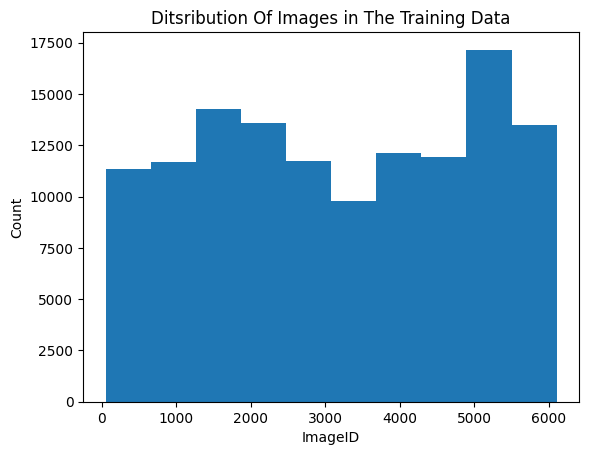

In [7]:
plt.hist(trainPairs.reshape(-1))
plt.title("Ditsribution Of Images in The Training Data")
plt.xlabel("ImageID")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

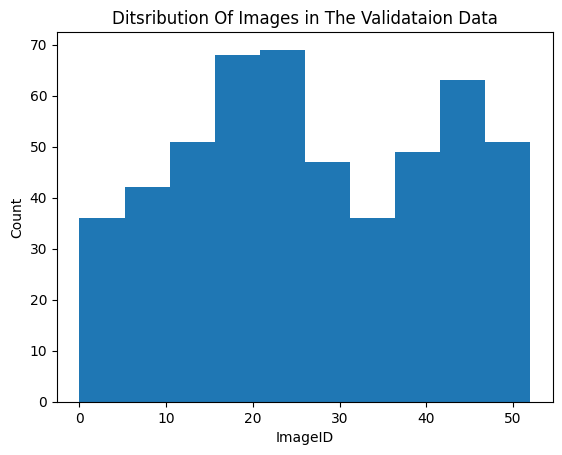

In [9]:
plt.hist(testPairs.reshape(-1))
plt.title("Ditsribution Of Images in The Validataion Data")
plt.xlabel("ImageID")
plt.ylabel("Count")

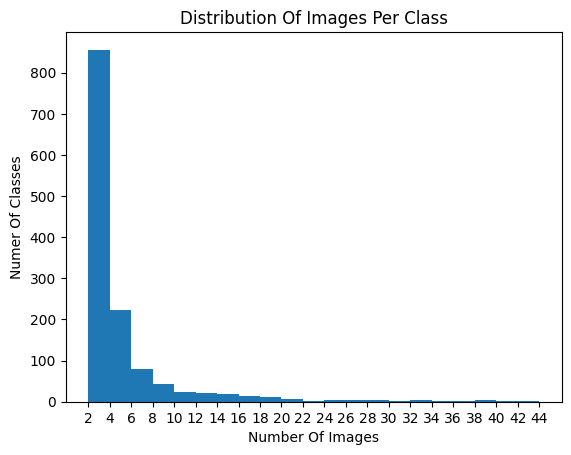

In [16]:
plotter.plotImgCountHist()

100%|████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1790.82it/s]


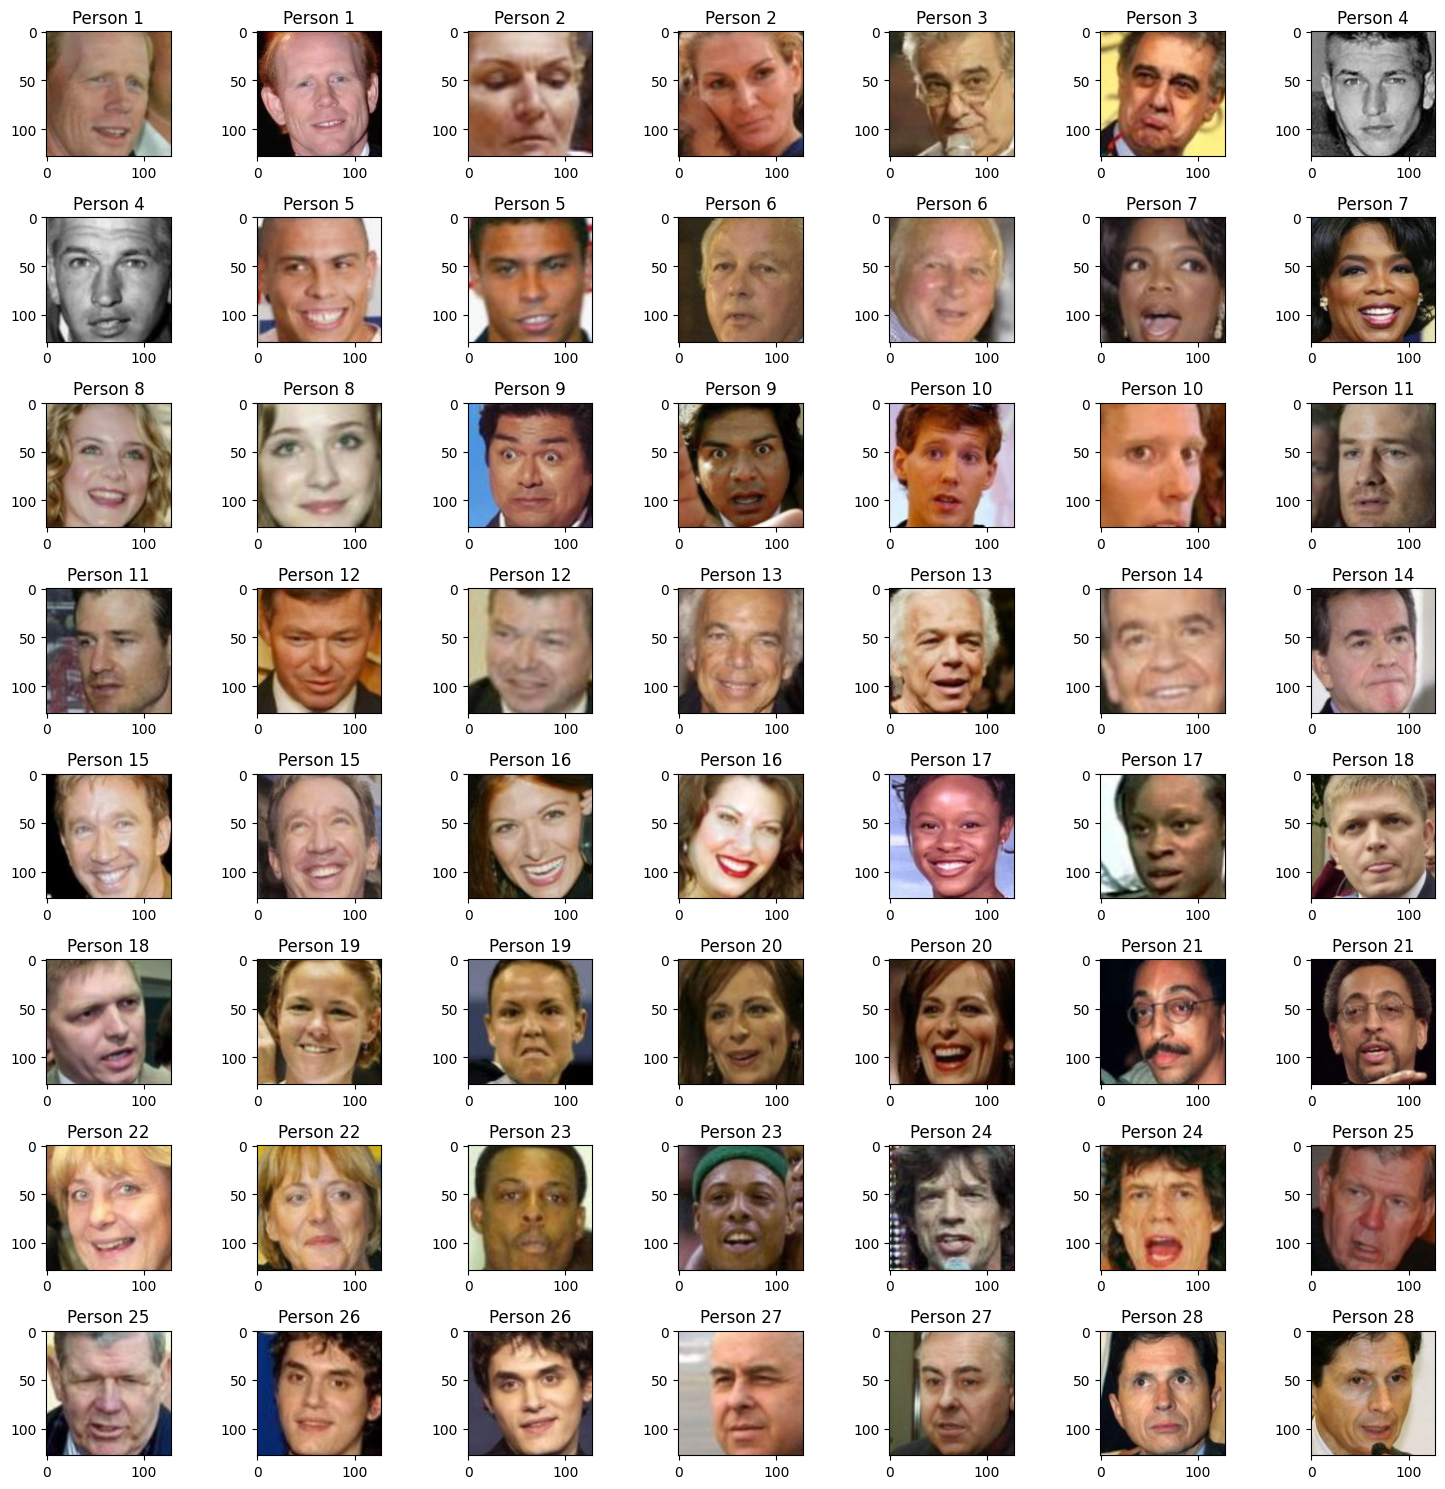

In [11]:
plotter.visualizeImages(nPersons=28, nImagesPerPerson=2, figSize=(15, 15))

# Create The Model

In [18]:
# Custom data generator
class Generator(keras.utils.Sequence):
    """
    Based on https://keras.io/api/utils/python_utils/#sequence-class
    A data generator that generates batches of pairs of images along with their labels.
    
    Parameters:
        metadata (pandas.DataFrame): The metadata of the images.
        pairs (numpy.ndarray): The pairs of image IDs.
        labels (numpy.ndarray): The labels of the pairs (0 for negative pairs and 1 for positive pairs).
        dataPath (str): The path to the directory where the images are located.
        batchSize (int): The size of each batch.
        inputShape (tuple): The shape of the input images.
        shuffle (bool, optional): Whether to shuffle the pairs after each epoch. Default is True.

    Methods:
        __len__(self): Returns the number of batches in each epoch.
        __getitem__(self, idx): Returns the batch at the given index.
        on_epoch_end(self): Shuffles the pairs after each epoch.
        preprocess_image(self, img): Preprocesses the input image.
        prepare_batch(self, batch_pairs, batch_labels): Preprocesses the input pairs and labels.

    Usage:
        generator = Generator(metadata, pairs, labels, dataPath, batchSize, inputShape, shuffle=True)
        model.fit(generator, epochs=10)
    """
    
    def __init__(self, metadata, pairs, labels, dataPath, batchSize, inputShape, shuffle=True):
        self.inputShape = inputShape
        self.dataPath = dataPath
        self.metadata = metadata
        self.pairs = pairs
        self.labels = labels
        self.batchSize = batchSize
        self.shuffle = shuffle
        self.num_batches = self.__len__()
        self.shuffleData()
        
    
    def shuffleData(self):
        perm = np.random.permutation(len(self.pairs))
        self.pairs = self.pairs[perm]
        self.labels = self.labels[perm]
        
        
    def preprocessImage(self, img):
        """
        Preprocesses the input image.

        parameters:
            img (numpy.ndarray): The input image.

        Returns:
            numpy.ndarray: The preprocessed image.
        """
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.reshape(self.inputShape)
        img = img / 255.0
        return img
    
    
    def __len__(self):
        """
        Returns the number of batches that will be generated by the generator.
        """
        return int(np.ceil(len(self.pairs) / self.batchSize))
    
    
    def __getitem__(self, idx):
        """
        Returns the batch at the given index.

        Parameters:
            idx (int): The index of the batch to return.

        Returns:
            tuple: A tuple containing two numpy arrays.
                The first array is a numpy array of shape (batch_size, 2, image_height, image_width, 1) representing the preprocessed image pairs,
                and the second array is a numpy array of shape (batch_size,) representing the labels (1 for positive pairs, 0 for negative pairs).
        """
        pairs = self.pairs[idx * self.batchSize: (idx + 1) * self.batchSize]
        labels = self.labels[idx * self.batchSize: (idx + 1) * self.batchSize]
        
        [x1, x2], y = self.prepareBatch(pairs, labels)
        
        return [x1, x2], y
    
    
    def on_epoch_end(self):
        """
        Shuffles the data at the end of an epoch if the `shuffle` parameter is set to True.
        
        Returns: None
        """
        if self.shuffle:
            self.shuffleData()
                
    
    def prepareBatch(self, pairs, labels):
        """
        Preprocesses and prepares the data for the current batch.

        Parameters:
            pairs (numpy.array): The array containing the information for the current batch.
            labels (numpy.array): The array containing the labels for the current batch.

        Returns:
            tuple: A tuple containing the preprocessed data and labels.
                   The first element is a numpy array of shape (batchSize, 2, image_height, image_width, 1) representing the preprocessed image pairs,
                   and the second element is a numpy array of shape (batchSize,) representing the labels (1 for positive pairs, 0 for negative pairs).
        """
        x1Batch = []
        x2Batch = []
        yBatch = []
        
        
        for i, imgIDs in enumerate(pairs):
            relativePaths = [self.metadata[self.metadata.ImageID == imgID].RelativePath.values[0] for imgID in imgIDs]
            absPaths = [os.path.join(self.dataPath, relativePath) for relativePath in  relativePaths]
            
            img1 = self.preprocessImage(cv2.imread(os.path.join(self.dataPath, absPaths[0])))
            img2 = self.preprocessImage(cv2.imread(os.path.join(self.dataPath, absPaths[1])))
            
            x1Batch.append(img1)
            x2Batch.append(img2)
            yBatch.append(labels[i])

        return [np.array(x1Batch, dtype='float32'), np.array(x2Batch, dtype='float32')], np.array(yBatch, dtype='float32')

### Custom Keras Layer
The AbsDistance class is a custom Keras layer that calculates the absolute difference between two input tensors. It takes no arguments during initialization. It has a single method call(inputs) which takes two input tensors and returns their absolute difference.

### Siamese Network Model
The Model class is a Siamese Network model that can be used to train and evaluate image similarity. It takes the following arguments during initialization:

### Methods:

#### _createConvModel(): A private method that creates the encoder part of the Siamese Network model. It takes no arguments and returns a keras.Sequential model object.
#### _createSimeseNet(): A private method that creates the complete Siamese Network model. It takes no arguments and returns a keras.Model object.
#### _build(): A private method that builds the complete Siamese Network model.
#### train(): A method that trains the Siamese Network model using the specified parameters.
#### _save(): A private method that saves the trained model to the specified save path.
#### clearSession(): A static method that clears the Keras backend session.
#### modelExists(): A method that checks if the model already exists in the specified save path. Returns True if the model exists, False otherwise.

In [40]:
# Create a custom layer to calculate the difference between two feature sets
class AbsDistance(keras.layers.Layer):
    """Calculates absolute distance between two tensors."""
    
    def __init__(self, name="absDistance", **kwargs):
        super().__init__(name=name, **kwargs)
    
    def call(self, inputs):
        return keras.backend.abs(inputs[0] - inputs[1])

    
class Model:
    def __init__(self, trainGen, validationGen,
                 inputShape, epochs, batchSize, savePath,
                 useBatchNorm, convLayersParams, convKernelSize, denseLayers,
                 optimizer, lossFunction, LR=10e-3, epsilon=1e-7, saveOnEpoch=False, modelName=""):
        self.hasBeenTrained = False
        
        self.trainGen = trainGen
        self.validationGen = validationGen
        self.inputShape = inputShape
        self.epochs = epochs
        self.batchSize = batchSize
        self.savePath = savePath
        self.useBatchNorm = useBatchNorm
        self.convLayersParams = convLayersParams
        self.convKernelSize = convKernelSize
        self.denseLayers = denseLayers
        self.optimizer = optimizer
        self.lossFunction = lossFunction
        self.LR = LR
        self.epsilon = epsilon
        
        self.callBacks = []
        self.metrics = ["accuracy"]
        self.optimizer = keras.optimizers.Adam(learning_rate=self.LR, epsilon=self.epsilon)
        self.modelName = f"{modelName}ConvUnits{self.convLayersParams}--Kernel{str(self.convKernelSize)}--DenseUnits{str(self.denseLayers)}--BatchNormState={str(self.useBatchNorm)}--BatchSize{self.batchSize}"

        self.TensorBoard_Log_Dir = r"./logs/" + self.modelName
        self.TensorBoard_CallBack = tf.keras.callbacks.TensorBoard(
                                log_dir=self.TensorBoard_Log_Dir,
                                histogram_freq=1,
                                write_graph=True,
                                write_images=True,
                                write_steps_per_second=True
                            )
        self.callBacks.append(self.TensorBoard_CallBack)
        
        if saveOnEpoch:
            self.modelCheckpoint = keras.callbacks.ModelCheckpoint(os.path.join(self.savePath,
                                                                                "AutoSaves",
                                                                                'AutoSave--epoch{epoch:02d}--Val_Loss{val_loss:.2f}' + f'--{self.modelName}.h5'),
                                                                                 monitor='val_loss',
                                                                                 save_weights_only=False)

            self.callBacks.append(self.modelCheckpoint)
        
        # Build the model
        self._build()
        
        
    def _createConvModel(self): 
        """ Creates the encoder part of the Simese Net. """

        model = keras.Sequential(name=f"encoder")
        model.add(Input(self.inputShape))

        for nParams in self.convLayersParams: 
            model.add(Conv2D(nParams, self.convKernelSize, activation='relu', padding='same'))
            
            if self.useBatchNorm:
                model.add(BatchNormalization())
                
            model.add(MaxPooling2D((2, 2)))

        model.add(Flatten())
        model.add(Dropout(0.2))
        
        for nParams in self.denseLayers:
            model.add(Dense(nParams, activation='relu'))

        #model.summary()
        return model
    
    
    # Create the Simese Network
    def _createSimeseNet(self):
        input1 = Input(self.inputShape, name="input1")
        input2 = Input(self.inputShape, name="input2")

        convModel = self._createConvModel()

        encoded1 = convModel(input1)
        encoded2 = convModel(input2)

        distanceLayer = AbsDistance()([encoded1, encoded2])
        output = Dense(1, activation='sigmoid', name="OutputLayer")(distanceLayer)

        siameseNet = keras.Model(inputs=[input1, input2], outputs=output, name=f"SimameseNetwork")

        return siameseNet
    
    
    def _build(self):
        self.siameseNet = self._createSimeseNet()
        #self.siameseNet.summary()
    
    
    def train(self):
        if self.modelExists():
            print("Model already exists. Aborting...")
            return
        
        if self.hasBeenTrained:
            print("Model has been trained. Skipping...")
            return
        
        self.siameseNet.compile(optimizer=self.optimizer,
                                loss=self.lossFunction,
                                metrics=self.metrics
                                )
        try:
            self.siameseNet.fit(self.trainGen,
                validation_data = self.validationGen,
                batch_size=self.batchSize,
                epochs=self.epochs,
                callbacks=self.callBacks
                )
            self.hasBeenTrained = True
        
        finally:
            self._save()
            self.clearSession()
    
    
    def _save(self):
        if self.hasBeenTrained:
            self.siameseNet.save(os.path.join(self.savePath, self.modelName + ".h5"))
    
    
    @staticmethod
    def clearSession():
        keras.backend.clear_session()
    
    
    def modelExists(self):
        if os.path.isfile(os.path.join(self.savePath, self.modelName + ".h5")):
            return True
        
        return False

# Finiding The Best Model Architecture 

##### This script tests different configurations for the model for further analysis.
##### The script trains the models for a few epochs and logs the training and validation metrics to TensorBoard for further analysis.
##### The best model configuration is then selected based on the TensorBoard logs and trained again.

In [41]:
modelSavePath = r"D:/CS/Projects/Single_Shot_Learning/models"
inputShape = (128, 128, 1)
LR = 10e-3
epsilon = 1e-7

optimizer = "adam"
lossFunction = "binary_crossentropy"

batchSize = 32
epochs = 3

cnovConfigs = [[256, 128, 64, 32], [32, 64, 128, 256], [32, 32, 32, 32, 32]]
denseConfigs = [[], [512, 256], [128], [64]]
kernelSizes = [(3, 3), (5, 5), (7, 7)]
metrics = ["accuracy"]

In [42]:
# Build diffrent models with diffrent architectures
trainGen = Generator(trainMetadata, trainPairs, trainLabels, dataPath, batchSize, inputShape)
validationGen = Generator(testMetadata, testPairs, testLabels, dataPath, batchSize, inputShape)
models = []

for convConfig in cnovConfigs:
    for kernelSize in kernelSizes:
        for denseConfig in denseConfigs:
             for useBatchnorm in [True]:
                model = Model(trainGen, validationGen,
                             inputShape, epochs, batchSize, modelSavePath,
                             useBatchnorm, convConfig, kernelSize, denseConfig,
                             optimizer, lossFunction
                             )
                
                models.append(model)

In [43]:
# Train the models for 3 epochs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

for i in tqdm(range(len(models))):
    try:
        model = models[i]
        print(f"Index: {i}, Model_Name: {model.modelName}")
        model.train()
           
    except Exception as e:
        print(e)
        pass

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


100%|███████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 12011.37it/s]

Index: 0, Model_Name: ConvUnits[256, 128, 64, 32]--Kernel(3, 3)--DenseUnits[]--BatchNormState=True--BatchSize32
Model already exists. Aborting...
Index: 1, Model_Name: ConvUnits[256, 128, 64, 32]--Kernel(3, 3)--DenseUnits[512, 256]--BatchNormState=True--BatchSize32
Model already exists. Aborting...
Index: 2, Model_Name: ConvUnits[256, 128, 64, 32]--Kernel(3, 3)--DenseUnits[128]--BatchNormState=True--BatchSize32
Model already exists. Aborting...
Index: 3, Model_Name: ConvUnits[256, 128, 64, 32]--Kernel(3, 3)--DenseUnits[64]--BatchNormState=True--BatchSize32
Model already exists. Aborting...
Index: 4, Model_Name: ConvUnits[256, 128, 64, 32]--Kernel(5, 5)--DenseUnits[]--BatchNormState=True--BatchSize32
Model already exists. Aborting...
Index: 5, Model_Name: ConvUnits[256, 128, 64, 32]--Kernel(5, 5)--DenseUnits[512, 256]--BatchNormState=True--BatchSize32
Model already exists. Aborting...
Index: 6, Model_Name: ConvUnits[256, 128, 64, 32]--Kernel(5, 5)--DenseUnits[128]--BatchNormState=True--

# Training

In [13]:
convUnits = [32, 64, 128, 256]
kernelSize = (5, 5)
denseUnits = []
useBatchNorm = 1

epochs = 5

trainGen = Generator(trainMetadata, trainPairs, trainLabels, dataPath, batchSize, inputShape)
validationGen = Generator(testMetadata, testPairs, testLabels, dataPath, batchSize, inputShape)

model = Model(trainGen, validationGen,
             inputShape, epochs, batchSize, modelSavePath,
             useBatchNorm, convUnits, kernelSize, denseUnits,
             optimizer, lossFunction, saveOnEpoch=True, modelName= "FINAL-30Epochs--"
             )
model.train()

Epoch 1/20
1963/1963 [==============================] - 399s 198ms/step - loss: 1.0148 - accuracy: 0.6738 - val_loss: 0.5194 - val_accuracy: 0.7544
Epoch 2/20
1963/1963 [==============================] - 410s 209ms/step - loss: 0.4141 - accuracy: 0.8120 - val_loss: 0.2904 - val_accuracy: 0.8817
Epoch 3/20
1963/1963 [==============================] - 406s 207ms/step - loss: 0.3197 - accuracy: 0.8635 - val_loss: 0.3613 - val_accuracy: 0.8284
Epoch 4/20
1963/1963 [==============================] - 430s 219ms/step - loss: 0.2597 - accuracy: 0.8932 - val_loss: 0.3006 - val_accuracy: 0.8669
Epoch 5/20
1963/1963 [==============================] - 457s 233ms/step - loss: 0.2196 - accuracy: 0.9113 - val_loss: 0.2817 - val_accuracy: 0.8639
Epoch 6/20
1963/1963 [==============================] - 429s 218ms/step - loss: 0.1780 - accuracy: 0.9297 - val_loss: 0.3174 - val_accuracy: 0.8846
Epoch 7/20
1963/1963 [==============================] - 430s 219ms/step - loss: 0.1489 - accuracy: 0.9402 - val_